#  Domain Gap Mitigation Strategy: Rotational Analysis

### Visualizations for the manuscript
"Towards fully automated inner ear analysis with deep-learning-based joint segmentation and landmark detection framework" by Jannik Stebani, Martin Blaimer, Simon Zabler, Tilmann Neun, Daniël M. Pelt and Kristen Rak

Usage Notes:

This notebook bundles visualizations and explanations about the improved data preprocessing and standardization strategy.
In the content presented below, you will find intermixed code, explanations and visualizations.

For a **quick skim** of the document, you may jump to the introductory statement under the next heading _Domain Gap Mitigation Strategy_ and then
make your way through the notebook via the markdown and plain text cells, skipping the `python` code cells.
The 3D `plotly` visualizations are also numbered for external referencing.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from pathlib import Path
from copy import deepcopy

In [2]:
from src.vector import build_vectors, Vector, as_normalized_origin_vector, angle
from src.vectorplots import TraceBuilder

In [3]:
directory = Path('./data/')

In [33]:
landmarks_data = [
    'spatialdata-B.json',
    'spatialdata-A.json',
    'spatialdata-W.json',
    'spatialdata-O.json',
    'spatialdata-G.json'
]
landmarks = []
for fname in landmarks_data:
    fpath = directory / fname
    with fpath.open(mode='r') as handle:
        landmarks.append(json.load(handle))

In [34]:
(clin_dataset_landmarks, exvo_dataset_landmarks,
 wim_dataset_landmarks, sib_dataset_landmarks,
 ger_dataset_landmarks) = landmarks

In [36]:
vectors_clin = build_vectors(clin_dataset_landmarks, 'RoundWindow', 'CochleaTop')
vectors_exvo = build_vectors(exvo_dataset_landmarks, 'RoundWindow', 'CochleaTop')
vectors_wim = build_vectors(wim_dataset_landmarks, 'RoundWindow', 'CochleaTop')
vectors_sib = build_vectors(sib_dataset_landmarks, 'RoundWindow', 'CochleaTop')
vectors_ger = build_vectors(ger_dataset_landmarks, 'RoundWindow', 'CochleaTop')


# Domain Gap Mitigation Strategy

## Spatial Orientation Analysis

For our domain gap investigation and subsequent mitigation strategy, we used the test-time augmentation framework to gain insights about the performance dropoff observed for some instances of the open source datasets. Using a wide array of test time augmentations, we observed a performance increase for certain rotation states of the input datasets.

To quantify the rotation state of a certain dataset instance, we compute the vector pointing from the round window landmark annotation towards the apex of the cochlea (internally called 'CochleaTop').
An example illustrative rendering for this vector is given below. We utilize the $\mathrm{IJK}$ voxel coordinate system for this task. 

<img src="data/jupyter-vector-annotated.png">

In [8]:
e_K = Vector(dataset_ID='KAXIS', base_landmark_label='ORIGIN', terminal_landmark_label='KDIR',
            base=np.array((0,0,0)), terminal=np.array((0,0,1)), shape=np.array((100, 100, 100)))

#### Angles for K-axis

We can calculate this parameter and take a look at the angles, that the RoundWindow->Apex vectors enclose with the $\mathrm{K}$-axis of the voxel cooridnate system.

In [37]:
exvo_angles = [angle(e_K, v) for v in vectors_exvo]
clin_angles = [angle(e_K, v) for v in vectors_clin]
wim_angles = [angle(e_K, v) for v in vectors_wim]
sib_angles = [angle(e_K, v) for v in vectors_sib]
ger_angles = [angle(e_K, v) for v in vectors_ger]


We observe that the instances of Datasets A and B all lie within a defined band of angles. Instances from the datasets W, O and G have no such angle distribution. 

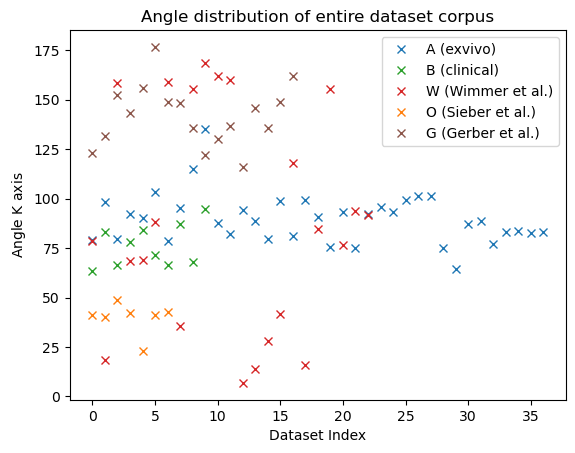

In [38]:
fig, ax = plt.subplots()
ax.plot(exvo_angles, marker='x', ls='', label='A (exvivo)', color='tab:blue')
ax.plot(clin_angles, marker='x', ls='', label='B (clinical)', color='tab:green')

ax.plot(wim_angles, marker='x', ls='', label='W (Wimmer et al.)', color='tab:red')
ax.plot(sib_angles, marker='x', ls='', label='O (Sieber et al.)', color='tab:orange')
ax.plot(ger_angles, marker='x', ls='', label='G (Gerber et al.)', color='tab:brown')


ax.set(xlabel='Dataset Index', ylabel='Angle $\mathrm{K}$ axis')
ax.set_title('Angle distribution of entire dataset corpus')
ax.legend()

We can further normalize of the vectors by scaling the components with the $L_2$ norm of the vector. This is performed in the cell below. The next step in the analysis is the computation of a mean orientation vector that indicates any preferential directions present in the respective datasets.

In [58]:
nvectors_clin = [as_normalized_origin_vector(v) for v in vectors_clin]
nvectors_exvo = [as_normalized_origin_vector(v) for v in vectors_exvo]
nvectors_wim = [as_normalized_origin_vector(v) for v in vectors_wim]
nvectors_sib = [as_normalized_origin_vector(v) for v in vectors_sib]
nvectors_ger = [as_normalized_origin_vector(v) for v in vectors_ger]

In [59]:
nvzip = zip(
    ['exvivo', 'clinical', 'wimmer', 'sieber', 'gerber'],
    [nvectors_exvo, nvectors_clin, nvectors_wim, nvectors_sib, nvectors_ger]
)
mean_str = ''
for name, vectorset in nvzip:
    mean = np.zeros(3)
    for v in vectorset:
        mean += v.delta
    mean /= len(vectorset)
    mean_str += f'v_{name}_mean = {mean}\n'
print(mean_str)

v_exvivo_mean = [ 0.07166372 -0.94792067  0.00671132]
v_clinical_mean = [-0.03682835 -0.90414207  0.23284683]
v_wimmer_mean = [0.15129983 0.01986298 0.02080817]
v_sieber_mean = [ 0.26164056 -0.13932628  0.76141343]
v_gerber_mean = [ 0.03389408  0.52059236 -0.75951796]



The values given above show that datasets A and B possess a large component along the second $\mathrm{J}$ axis pointing in negative direction.
This is in accordance with standard operating procedure in clinical practice.
 - The dataset W by Wimmer et al. has its largest component along the first $\mathrm{I}$ axis.
 - The dataset O by Sieber et al. has its largest component along the trailing $\mathrm{K}$ axis.
 - The dataset G by Gerber et al. has its largest component along the negative trailing $\mathrm{K}$ axis.
  

#### 3D Visualization

Having observed this, we proceed to 3D visualizations of the phenomenon.

In [60]:
tb = TraceBuilder()
tb.tip_fraction = 0.9
tb.start_fraction = 0.98

Normalized vector traces

In [72]:
tb.line_color = 'blue'
vectortraces_clin = tb.from_vectors(nvectors_clin)
tb.line_color = 'green'
vectortraces_exvo = tb.from_vectors(nvectors_exvo)
tb.line_color = 'red'
vectortraces_wim = tb.from_vectors(nvectors_wim)
tb.line_color = 'yellow'
vectortraces_sib = tb.from_vectors(nvectors_sib)
tb.line_color = 'brown'
vectortraces_ger= tb.from_vectors(nvectors_ger)

Raw vector traces

In [62]:
vectors_sib

[Vector(dataset_ID='alpha_1_UE', base_landmark_label='RoundWindow', terminal_landmark_label='CochleaTop', base=array([ 56, 110, 120]), terminal=array([ 82, 152, 176]), shape=array([212, 189, 247]), delta=array([26, 42, 56]), _rotation_state=0),
 Vector(dataset_ID='delta_4_UE', base_landmark_label='RoundWindow', terminal_landmark_label='CochleaTop', base=array([ 62, 119, 110]), terminal=array([ 74, 164, 165]), shape=array([208, 203, 236]), delta=array([12, 45, 55]), _rotation_state=0),
 Vector(dataset_ID='epsilon_3_UE', base_landmark_label='RoundWindow', terminal_landmark_label='CochleaTop', base=array([ 59,  83, 110]), terminal=array([ 90,  38, 158]), shape=array([203, 218, 227]), delta=array([ 31, -45,  48]), _rotation_state=0),
 Vector(dataset_ID='eta_5_UE', base_landmark_label='RoundWindow', terminal_landmark_label='CochleaTop', base=array([ 62,  85, 120]), terminal=array([ 85,  38, 178]), shape=array([232, 198, 255]), delta=array([ 23, -47,  58]), _rotation_state=0),
 Vector(datase

In [73]:
tb.line_color = 'blue'
raw_vectortraces_clin = tb.from_vectors(vectors_clin)
tb.line_color = 'green'
raw_vectortraces_exvo = tb.from_vectors(vectors_exvo)
tb.line_color = 'red'
raw_vectortraces_wim = tb.from_vectors(vectors_wim)
tb.line_color = 'yellow'
raw_vectortraces_sib = tb.from_vectors(vectors_sib)
tb.line_color = 'brown'
raw_vectortraces_ger = tb.from_vectors(vectors_ger)

In [74]:
global_layout_kwargs = {
    'legend_title_text' : 'Dataset Instance ID',
    'scene' :  dict(xaxis_title='I axis', yaxis_title='J axis', zaxis_title='K axis'),
    'width' : 1500, 'height' : 850
}

In [75]:
fig = go.Figure()

fig.add_traces(raw_vectortraces_clin)
fig.add_traces(raw_vectortraces_exvo)
fig.update_layout(
    title='SupVis.1: Raw IJK space Vector Plot: In-House datasets',
    **global_layout_kwargs
)

fig.show()

Above, we can observe the orientation of datasets obtained in a standardized clinical procedure.

In [66]:
fig = go.Figure()

fig.add_traces(vectortraces_clin)
fig.add_traces(vectortraces_exvo)
fig.update_layout(
    title='SupVis.2: Normalized Origin Vector Plot: In-House Datasets',
    **global_layout_kwargs
)

fig.show()

Summarizingly, we observe that the training and validation dataset instances (Dataset **A**, $N_{\mathrm{train}}=43$ and $N_{\mathrm{validation}}=5$, exvivo scans of cadaveric specimen) in blue and the test data instances in blue (Dataset **B**, $N_{\mathrm{test}}=10$) possess a preferential orientation in $\mathrm{IJK}$ voxel space.
This precipitates in the mean orientation vector that we calculated for both the datasets:
$$\langle \mathbf{v}_{\mathrm{A}}\rangle = (0.07166, -0.94792,  0.00671)^{\mathrm{T}}$$
$$\langle \mathbf{v}_{\mathrm{B}}\rangle = (-0.03682, -0.90414,  0.23284)^{\mathrm{T}}$$
The large component along the $\mathrm{J}$ axis encodes this observation quantitatively.
The consistent orientation of the inner ear anatomy in the datasets is in accordance with standard operating procedure in clinical practice, where patients are placed in the scanner apparatus under the guidance of a domain expert.
Note that two dataset instances from Dataset **A** (instance ID 17 and 18) have differing angle orientation that falls outside of the described cone. 

We can further compute the angle between the vectors of instance '10_AV' and instance '04_BB' to get an estimate for the opening angle of the cone

In [67]:
AV10 = list(filter(lambda v: v.dataset_ID == '10_AV', vectors_clin))[0]
BB04 = list(filter(lambda v: v.dataset_ID == '04_BB', vectors_clin))[0]
                                                                    
(AV10, BB04)

(Vector(dataset_ID='10_AV', base_landmark_label='RoundWindow', terminal_landmark_label='CochleaTop', base=array([271, 297, 197]), terminal=array([299, 231, 191]), shape=array([512, 512, 405]), delta=array([ 28, -66,  -6]), _rotation_state=0),
 Vector(dataset_ID='04_BB', base_landmark_label='RoundWindow', terminal_landmark_label='CochleaTop', base=array([217, 279, 222]), terminal=array([181, 223, 236]), shape=array([512, 512, 405]), delta=array([-36, -56,  14]), _rotation_state=0))

In [68]:
angle(AV10, BB04)

57.85636743681466

We observe from the above computation that the opening angle of the cone defined by the standard operating procedure in clinical practice is approximately $\theta_{o}\approx 60 ^{\circ}$

In [76]:
fig = go.Figure()

fig.add_traces(raw_vectortraces_wim)
fig.add_traces(raw_vectortraces_sib)
fig.add_traces(raw_vectortraces_ger)


fig.update_layout(
    title='SupVis.3: Raw IJK Space Vector Plot: Open Source Datasets',
    **global_layout_kwargs
)

fig.show()

The above 3D visualization clearly demonstrates that the open source datasets W by Wimmer et al. and O by Sieber et al. do not have this preferential orientation.
We look at the normalized orientation vector distribution below:

In [77]:
fig = go.Figure()

fig.add_traces(vectortraces_wim)
fig.add_traces(vectortraces_sib)
fig.add_traces(vectortraces_ger)


fig.update_layout(
    title='SupVis.4: Normalized Origin Vector Plot: Open Source Datasets',
    **global_layout_kwargs
)

fig.show()

We could identify the non-standard imaging protocol as a major contributor to the domain gap. It appears that [Wimmer et al.](https://doi.org/10.1016/j.dib.2019.104782), [Sieber et al.](https://doi.org/10.1038/sdata.2018.297) and [Gerber et al.](https://doi.org/10.1038/sdata.2017.132) employed no standardized clinical orientation procedure during the recording of their scans of cadaveric specimens.

We thusly identified both training and test-time augmentation with rotations around all three spatial axes with three rotations of angles $90^{\circ}$, $180^{\circ}$ and $270^{\circ}$ as one of the key strategies to mitigate the segmentation and localization domain gap induced by the otherwise too large input data domain shift.

Based on the preprocessing and data augmentation strategies described by [Neves et al.](https://doi.org/10.1038/s41598-020-80619-0), [Heutink et al.](https://doi.org/10.1016/j.cmpb.2020.105387) and Fauser et al. ([1](https://doi.org/10.1007/s11548-019-01937-x), [2](https://doi.org/10.1007/s11548-020-02270-4)), we surmise that the utilized in-house datasets all had similar anatomical orientation, in turn evading any input data domain shift difficulties. The same is true for the study by [Vaidyanathan et al.](https://doi.org/10.1038/s41598-021-82289-y) that is based on MRI data. This is in line with the fact that these studies declare clinical practice as their basal data source.

The TTA-strategy ensures that the trained framework receives open source datasets instances with view aspects that are consistent with standard operating procedure in clinical imaging.